In [23]:
# enable reload the module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Import the necessary modules
import argparse
import datetime
import glob
import os
import re
import time
from pathlib import Path

import numpy as np
import torch

from eval_utils import eval_utils
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets import build_dataloader
from mtr.models import model as model_utils
from mtr.utils import common_utils
from mtr.datasets.waymo.waymo_dataset import WaymoDataset
from torch.utils.data import DataLoader

from visualization.vis_utils import plot_map, plot_signal, plot_traj_with_time, plot_obj_pose, plot_traj_with_speed


In [25]:
# cfg_file = '/hdd/Git_Repo/MTR/tools/cfgs/waymo/mtr_eval.yaml'
cfg_file = '/home/zixuzhang/Documents/Git/MTR/tools/cfgs/waymo/eval.yaml'
cfg_from_yaml_file(cfg_file, cfg)
cfg.TAG = Path(cfg_file).stem
cfg.EXP_GROUP_PATH = '/'.join(cfg_file.split('/')[1:-1])  # remove 'cfgs' and 'xxxx.yaml'

np.random.seed(1024)

# Set the output directory
output_dir = cfg.ROOT_DIR / 'output' / 'val_interactive'
output_dir.mkdir(parents=True, exist_ok=True)

eval_output_dir = output_dir / 'eval'
eval_output_dir.mkdir(parents=True, exist_ok=True)

log_file = eval_output_dir / ('log_eval_%s.txt' % datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))


In [42]:
# Build dataset
test_set, test_loader, sampler = build_dataloader(
    dataset_cfg=cfg.DATA_CONFIG,
    batch_size=1,
    dist=False, workers=1, logger=None, training=False
)

In [44]:
# load model
model = model_utils.MotionTransformer(config=cfg.MODEL)
# ckpt_path = '/hdd/Git_Repo/MTR/model/checkpoint_epoch_30.pth'
ckpt_path = '/home/zixuzhang/Documents/Git/MTR/model/checkpoint_epoch_30.pth'
it, epoch = model.load_params_from_file(filename=ckpt_path, to_cpu=False)
model = model.cuda()

# Interesting case:
1. Val, 6, 2d84b1ab55ab81d3, U-turn vs Left-turn
2. Val, 7, 3505972c220e6b3a, Turn vs Striaght for merging
3. Val, 25, 6d2a107f2e8390a, Merge to main road
4. Val, 26, ae92386e0686d4d6, Complicated 4-way stop
5. Val, 27, 3d00a93f0ba5e294, Both car merge to main road
6. Val, 36, 31d18fac4011375c, illegal merging to the main road

31d18fac4011375c


(6200.0, 6350.0)

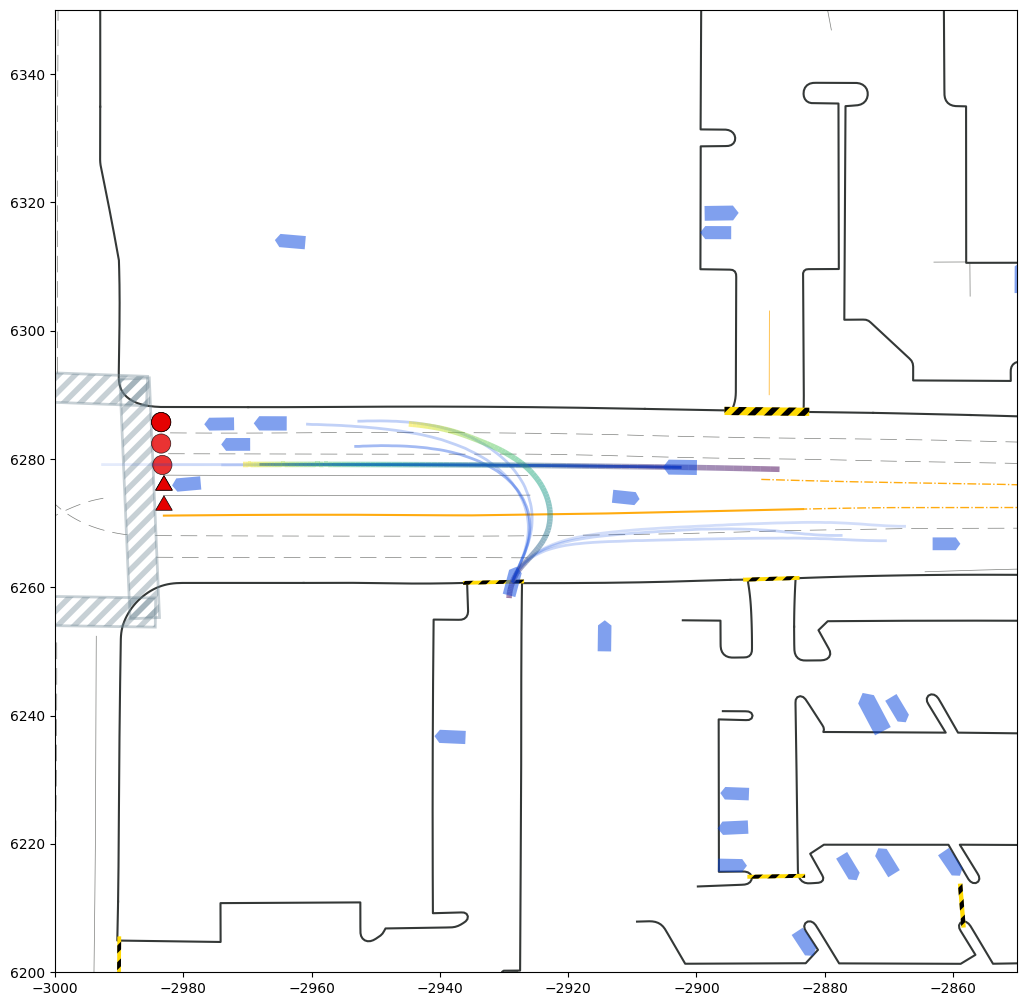

In [67]:
index = 36
shift = 0

model.eval()
batch_dict = test_set.collate_batch([test_set.create_scene_level_data(index, shift)])
with torch.no_grad():
    batch_pred_dicts = model(batch_dict)
    final_pred_dicts = test_set.generate_prediction_dicts(batch_pred_dicts)

scene_id, info = test_set.load_info(index)
print(scene_id)
fig, ax = plot_map(info['map_infos'], if_plot_lane=False)

t = 11+shift
dynamic_map_infos = info['dynamic_map_infos']
plot_signal(dynamic_map_infos, t, ax)

track_infos = info['track_infos']

for prediction in final_pred_dicts:
    pred_trajs = prediction['pred_trajs']
    pred_scores = prediction['pred_scores']
    for future, score in zip(pred_trajs, pred_scores):
        ax.plot(future[:, 0], future[:, 1], color='xkcd:blue', linewidth=2, linestyle='-', alpha=score*0.9+0.1, zorder=2)
    
    
for obj_idx in info['tracks_to_predict']['track_index']:
    plot_traj_with_time([track_infos['object_type'][obj_idx]], [track_infos['trajs'][obj_idx]], info['timestamps_seconds'], ax=ax, fig=fig,)
    # 
    
for obj_type, traj in zip(
    info['track_infos']['object_type'], info['track_infos']['trajs']
):
    plot_obj_pose(obj_type, traj[t], ax=ax)

ax.set_xlim(-3000, -2850)
ax.set_ylim(6200, 6350)
